In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
from ase.build import bulk

# Build a bulk structure of MgO with rocksalt crystal structure
# and a lattice constant of 4.2 Angstroms.
# Then, replace some of the Mg atoms with Fe atoms at a specified ratio.
Mg_conv_cell = bulk("MgO", crystalstructure="rocksalt", a=4.2, cubic=True)
rng = np.random.default_rng(42)
replace_element = "Mg"
new_elements=("Mg", "Fe")
T_low = 100
T_high = 1000
ratio = 0.5

In [ ]:
from monty.serialization import loadfn
import tc.dataset
import tc.testing
from mace.calculators import mace_mp

# Only create the ensembles if they do not already exist
try:
    ensemble = loadfn(f"{''.join(new_elements)}O_ensemble4.json.gz")
    print("Ensemble already exist, skipping creation.")
except FileNotFoundError:
    print("Creating new ensembles...")
    calc = mace_mp(model="large", device="cuda", default_dtype="float64")
    ensembles = tc.dataset.make_ce_ensembles_from_mace(conv_cell=Mg_conv_cell, rng=rng, calc=calc, ratio=ratio, 
                                                       replace_element=replace_element, new_elements=new_elements, bin_counts=200)
    # This is likely to run out of VRAM, which is why we save the ensembles when we create them.
    for ensemble in ensembles:
        stats = tc.testing.evaluate_ensemble_vs_mace(ensemble=ensemble, calc=calc, conv_cell=Mg_conv_cell, rng=rng, 
                                                     replace_element=replace_element, new_elements=new_elements)

    ensemble_4, ensemble_6, ensemble_8, ensemble_10 = ensembles
    ensemble = ensemble_4



/home/colin/miniforge/envs/tc312/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


Ensemble already exist, skipping creation.


  0%|          | 0/10000 [00:00<?, ?it/s]

CE energies: mean = -9778.11 meV, std =   477.10 meV, min = -11655.29 meV, max = -7335.10 meV
Energy window : [-21.706, 6.920] eV (200 bins, 0.1431 eV each)


Sampling 1 chain(s) from a cell with 512 sites: 100%|██████████| 256000000/256000000 [4:58:17<00:00, 14303.65it/s]  


Debug: ensemble.processor.size = 64
Debug: ensemble.num_sites = 512
Debug: ratio = 8.0
min(raw) = -19.987984541010754 eV
max(raw) = 5.632122830048257 eV
ΔE = 25.62010737105901 eV


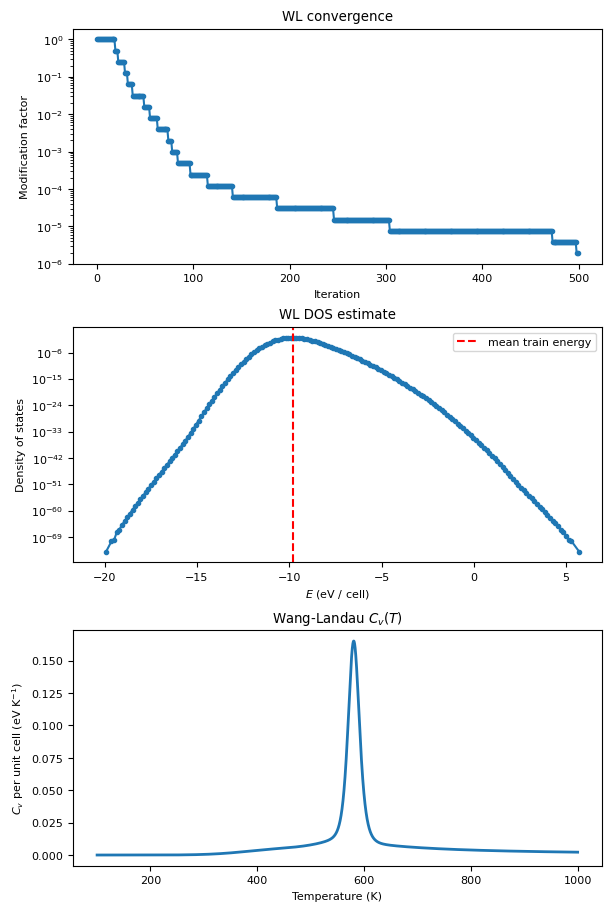

In [ ]:
"""
Single threaded Wang-Landau sampling
"""

import tc.wang_landau
import tc.testing

samples = tc.testing.sample_configs_fast(ensemble, rng, n_samples=10_000, ratio=ratio)
sampler, mu, min_E, max_E, bin_size = tc.wang_landau.run_wang_landau(ensemble=ensemble, samples=samples, rng=rng, ratio=ratio, n_samples_per_site=500_000, num_bins=200, window_width_factor=(25,35))
temperatures_K = np.linspace(T_low, T_high, 10_000)
Cv = tc.wang_landau.compute_thermodynamics(sampler, temperatures_K)
tc.wang_landau.generate_wl_plots( mu, min_E, max_E, bin_size, sampler, temperatures_K, Cv)

In [ ]:
"""
Parallel Metropolis heat-capacity sweep
"""

import os, numpy as np
from concurrent.futures import ProcessPoolExecutor
from tqdm.auto import tqdm
import tc.metropolis

# Temperatures to sample and an independent RNG seed for every worker (avoids accidental correlations).
Ts = np.linspace(T_low, T_high, 200)
seed_root = np.random.SeedSequence(42) # master seed
child_seeds = seed_root.spawn(len(Ts))

def _single_Cv(T, seed):
    rng = np.random.default_rng(seed)
    return tc.metropolis.run_metropolis_heat_capacity(
        ensemble, # cheap shallow copy is enough (I hope)
        T,
        rng,
        replace_element=replace_element,
        new_elements=new_elements,
        ratio=ratio,
        n_steps_per_site=10_000,
        thin_target=40_000,
    )

# Fan the temperature points out to all available cores.
n_workers = os.cpu_count() // 2 # type: ignore # leave some cores free for the GUI and other tasks for my laptop
print(f"Using {n_workers} workers for parallel sampling.")
with ProcessPoolExecutor(max_workers=n_workers) as pool:
    Cv = list(tqdm(pool.map(_single_Cv, Ts, child_seeds), total=len(Ts), desc="Metropolis", unit="T"))

tc.metropolis.plot_cv_curve(Ts, np.array(Cv))


Metropolis:   0%|          | 0/200 [00:00<?, ?T/s]